# Predicción de series de tiempo Holts-Winters

## Importamos dependecias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from datetime import timedelta

## Código para las metricas 

In [15]:
def rmse(y_true, y_pred):
    yt, yp = _pair_without_nan(y_true, y_pred)
    return np.sqrt(mean_squared_error(yt, yp))

def mape(y_true, y_pred):
    yt, yp = _pair_without_nan(y_true, y_pred)
    denom = np.clip(np.abs(yt), 1e-9, None)
    return np.mean(np.abs((yt - yp) / denom)) * 100

def _pair_without_nan(y_true, y_pred):
    yt = pd.Series(y_true)
    yp = pd.Series(y_pred)
    aligned = pd.concat([yt.rename("yt"), yp.rename("yp")], axis=1).dropna()
    return aligned["yt"].to_numpy(), aligned["yp"].to_numpy()

## Carga de datos

In [16]:
rng = pd.date_range("2022-01-01", periods=900, freq="D")
seasonal = 10*np.sin(2*np.pi*rng.dayofyear/7) # semanal
trend = 0.02*np.arange(len(rng))
noise = np.random.normal(0, 1.5, len(rng))
y = 50 + trend + seasonal + noise
df = pd.DataFrame({"date": rng, "y": y})

# --- TU DATA REAL ---
# df = pd.read_csv("tus_datos.csv")
# df["date"] = pd.to_datetime(df["date"])

# Asegurar orden y frecuencia
def prepare_ts(df, date_col='date', default_freq='D'):
    df = df.copy()
    # 1) convertir a datetime y limpiar
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce', utc=False)
    df = df.dropna(subset=[date_col]).sort_values(date_col)
    df = df.drop_duplicates(subset=[date_col])

    # 2) indexar por fecha
    df = df.set_index(date_col).sort_index()

    # 3) inferir frecuencia (con fallback si es irregular)
    freq = pd.infer_freq(df.index)
    if freq is None:
        # intentar deducirla por la mediana de diferencias
        diffs = df.index.to_series().diff().dropna()
        if not diffs.empty:
            try:
                from pandas.tseries.frequencies import to_offset
                freq = to_offset(diffs.median()).name
            except Exception:
                freq = default_freq
        else:
            freq = default_freq

    # 4) forzar grilla regular (insertará NaN si faltaban fechas)
    df = df.asfreq(freq)

    return df, freq

# Usa 'D' para diaria, 'MS' si es mensual (inicio de mes)
df, freq = prepare_ts(df, date_col='date', default_freq='D')
print("Frecuencia usada:", freq)
df.head()

Frecuencia usada: D


,y
date,
2022-01-01,59.298070
2022-01-02,57.874398
2022-01-03,56.741311
2022-01-04,46.733645
2022-01-05,38.933431


## EDA

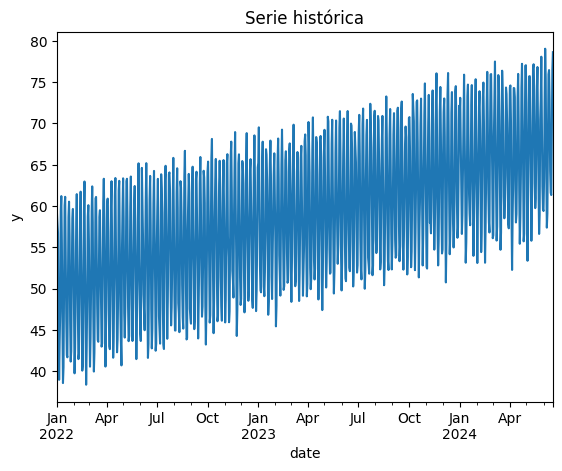

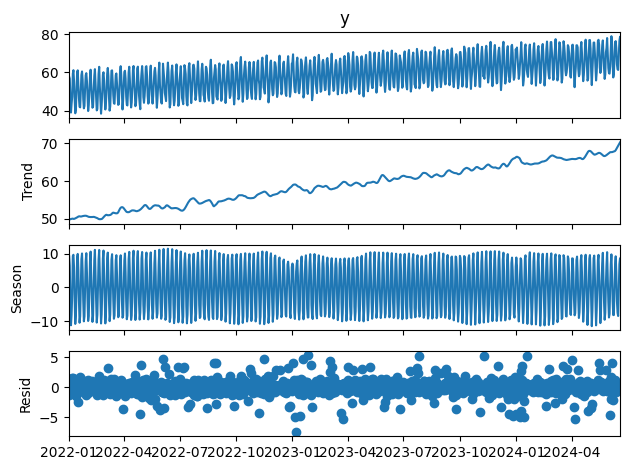

In [17]:
fig, ax = plt.subplots()
df["y"].plot(ax=ax, title="Serie histórica", ylabel="y")

# Descomposición STL (elige el periodo: 7 días si es diaria con semana; 12 si mensual con año)
seasonal_periods = 7  # cámbialo a 12 para datos mensuales
res = STL(df["y"].interpolate(), period=seasonal_periods, robust=True).fit()
res.plot()
plt.show()

In [18]:
if df["y"].isna().any():
    df["y"] = df["y"].interpolate(method="time").ffill().bfill()

## Split temporal (train / test)

In [19]:
test_size = int(len(df)*0.2)  # 20% test
y_train = df["y"][:-test_size]
y_test  = df["y"][-test_size:]
y_train.tail(), y_test.head()

(date
 2023-12-17    71.294211
 2023-12-18    73.806649
 2023-12-19    67.187289
 2023-12-20    57.903149
 2023-12-21    54.974642
 Freq: D, Name: y, dtype: float64,
 date
 2023-12-22    57.184277
 2023-12-23    63.165709
 2023-12-24    73.898077
 2023-12-25    74.524861
 2023-12-26    70.387247
 Freq: D, Name: y, dtype: float64)

## Baselines (Naive y Seasonal-Naive)

In [20]:
seasonal_periods = 7  # o 12 si es mensual, etc.

# Baseline naive
naive_pred = pd.Series(y_train.iloc[-1], index=y_test.index)

# Seasonal-naive (usa toda la serie para que el shift tenga datos “pasados”)
s_naive_full = df["y"].shift(seasonal_periods)
s_naive_pred = s_naive_full.reindex(y_test.index)

print("Baseline NAIVE  -> RMSE: %.3f | MAPE: %.2f%%" % (rmse(y_test, naive_pred), mape(y_test, naive_pred)))
print("Baseline S-NAIV -> RMSE: %.3f | MAPE: %.2f%%" % (rmse(y_test, s_naive_pred), mape(y_test, s_naive_pred)))

Baseline NAIVE  -> RMSE: 13.374 | MAPE: 16.13%
Baseline S-NAIV -> RMSE: 2.520 | MAPE: 3.03%


## Modelo STL + Holt-Winters (ETS)

In [21]:
def fit_ets(y, seasonal_periods=7, seasonal="add"):
    model = ExponentialSmoothing(
        y,
        trend="add",
        seasonal=seasonal,
        seasonal_periods=seasonal_periods,
        initialization_method="heuristic"
    ).fit(optimized=True, use_brute=False)
    return model

candidates = []
for seasonal in ["add", "mul"]:
    try:
        m = fit_ets(y_train, seasonal_periods=seasonal_periods, seasonal=seasonal)
        pred = m.forecast(len(y_test))
        candidates.append((seasonal, m, rmse(y_test, pred), mape(y_test, pred)))
    except Exception as e:
        print(f"Falló {seasonal=}: {e}")

for seasonal, m, r, mp in candidates:
    print(f"ETS({seasonal}) -> RMSE: {r:.3f} | MAPE: {mp:.2f}%")


# Elegir el mejor
best = sorted(candidates, key=lambda t: t[2])[0]  # por RMSE
best_seasonal, best_model, best_rmse, best_mape = best
print(f"\nMejor modelo: ETS({best_seasonal}) | RMSE: {best_rmse:.3f} | MAPE: {best_mape:.2f}%")

ETS(add) -> RMSE: 6.398 | MAPE: 8.50%
ETS(mul) -> RMSE: 6.497 | MAPE: 8.65%

Mejor modelo: ETS(add) | RMSE: 6.398 | MAPE: 8.50%


## Backtesting

In [22]:
def rolling_backtest(y, horizon=seasonal_periods, train_min=3*seasonal_periods):
    # Retorna RMSE/MAPE promedio en varias ventanas crecientes
    rmses, mapes = [], []
    for split in range(train_min, len(y)-horizon, horizon):
        y_tr = y.iloc[:split]
        y_te = y.iloc[split:split+horizon]
        try:
            m = fit_ets(y_tr, seasonal_periods=seasonal_periods, seasonal=best_seasonal)
            pred = m.forecast(len(y_te))
            rmses.append(rmse(y_te, pred))
            mapes.append(mape(y_te, pred))
        except:
            pass
    return np.mean(rmses), np.mean(mapes)

bt_rmse, bt_mape = rolling_backtest(df["y"].dropna())
print("Backtest ETS -> RMSE medio: %.3f | MAPE medio: %.2f%%" % (bt_rmse, bt_mape))

Backtest ETS -> RMSE medio: 1.746 | MAPE medio: 2.50%


## Pronóstico del fúturo


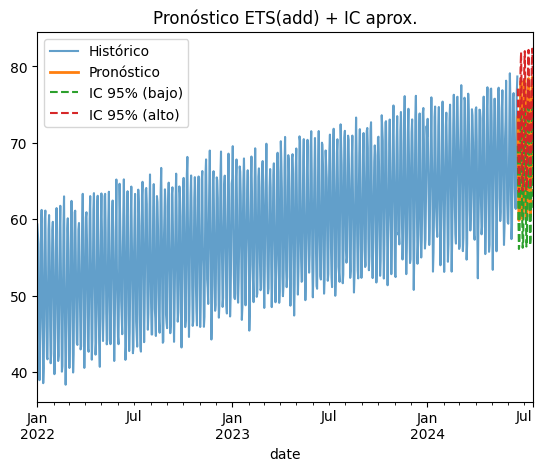

,yhat,yhat_lo,yhat_hi
2024-06-19,73.322915,69.586702,77.059129
2024-06-20,64.221557,60.485344,67.957771
2024-06-21,59.825799,56.089585,63.562012
2024-06-22,60.641411,56.905197,64.377625
2024-06-23,68.327862,64.591648,72.064075


In [23]:
# Re-entrenar con toda la serie
final_model = fit_ets(df["y"].interpolate(), seasonal_periods=seasonal_periods, seasonal=best_seasonal)

# Horizonte de pronóstico (ej.: 30 días si es diaria; 12 si mensual)
H = 30
fcst_index = pd.date_range(df.index[-1] + pd.tseries.frequencies.to_offset(df.index.freq or "D"),
                           periods=H, freq=df.index.freq or "D")
fcst = pd.Series(final_model.forecast(H), index=fcst_index)

# Intervalos de confianza aproximados usando residuo histórico
residuals = df["y"] - final_model.fittedvalues.reindex(df.index)
sigma = residuals.std(ddof=1)
ci95 = 1.96 * sigma
fcst_lo = fcst - ci95
fcst_hi = fcst + ci95

# Plot
ax = df["y"].plot(label="Histórico", alpha=0.7)
fcst.plot(ax=ax, label="Pronóstico", lw=2)
fcst_lo.plot(ax=ax, label="IC 95% (bajo)", linestyle="--")
fcst_hi.plot(ax=ax, label="IC 95% (alto)", linestyle="--")
plt.title(f"Pronóstico ETS({best_seasonal}) + IC aprox.")
plt.legend()
plt.show()

pd.DataFrame({"yhat": fcst, "yhat_lo": fcst_lo, "yhat_hi": fcst_hi}).head()

## Exportar resultados y guardar modelo

In [24]:
out = pd.DataFrame({"date": fcst.index, "yhat": fcst.values, "yhat_lo": fcst_lo.values, "yhat_hi": fcst_hi.values})
out.to_csv("forecast.csv", index=False)

# Guardar fitted values y residuales para monitoreo
diag = pd.DataFrame({
    "date": df.index,
    "y": df["y"].values,
    "fitted": final_model.fittedvalues.reindex(df.index).values,
})
diag["residual"] = diag["y"] - diag["fitted"]
diag.to_csv("model_diagnostics.csv", index=False)

out.head(), diag.tail()

(        date       yhat    yhat_lo    yhat_hi
 0 2024-06-19  73.322915  69.586702  77.059129
 1 2024-06-20  64.221557  60.485344  67.957771
 2 2024-06-21  59.825799  56.089585  63.562012
 3 2024-06-22  60.641411  56.905197  64.377625
 4 2024-06-23  68.327862  64.591648  72.064075,
           date          y     fitted  residual
 895 2024-06-14  61.614606  58.057733  3.556873
 896 2024-06-15  61.329177  59.728362  1.600815
 897 2024-06-16  69.289676  67.276686  2.012989
 898 2024-06-17  76.519952  74.980278  1.539673
 899 2024-06-18  78.642092  77.890753  0.751339)